In [79]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from geopandas.tools import sjoin
import pysal as ps
import numpy as np
%matplotlib inline

In [80]:
data=pd.read_csv('InputDataset.csv',dtype={'BGFIPS10':np.object}).set_index('BGFIPS10')
geo=gpd.read_file('Data/SF_BlockGroups10.shp').set_index('BGFIPS10')
gdf=gpd.GeoDataFrame(data, geometry=geo.geometry)


In [81]:
w=ps.queen_from_shapefile('Data/SF_BlockGroups10.shp', 'BGFIPS10')


Island id:  [576]


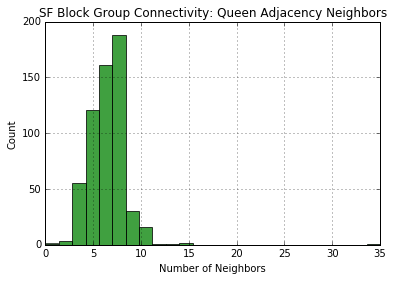

In [82]:
n, bins, patches = plt.hist(w.cardinalities.values(), 25, facecolor='green', alpha=0.75)

plt.xlabel('Number of Neighbors')
plt.ylabel('Count')
plt.title('SF Block Group Connectivity: Queen Adjacency Neighbors')
plt.grid(True)

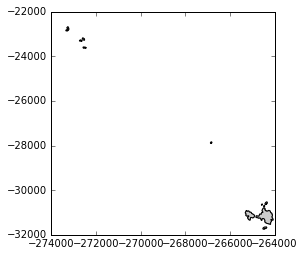

In [83]:
islandid=[k for k,v in w.cardinalities.iteritems() if v==0][0]
p=gpd.GeoSeries(geo.loc[islandid]).plot()

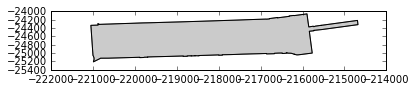

In [84]:
idmax=pd.Series(w.cardinalities).idxmax()
p=gpd.GeoSeries(geo.loc[idmax]).plot()

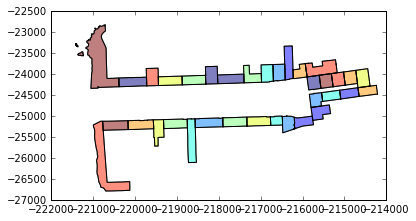

In [85]:
neigh_ids=w.neighbors[idmax]
p=geo.loc[neigh_ids].plot()

In [86]:
data=data[~data.index.isin([idmax, islandid,'060750179021'])]
geo=geo[~geo.index.isin([idmax, islandid,'060750179021'])]
geo.reset_index().to_file('Data/SF_BlockGroups10_Cleaned.shp')
gdf=gpd.GeoDataFrame(data, geometry=geo.geometry)
w=ps.queen_from_shapefile('Data/SF_BlockGroups10_Cleaned.shp', 'BGFIPS10')

In [87]:
w.weights.values()[4]

[1.0, 1.0, 1.0, 1.0]

In [88]:
w.transform='r'
w.weights.values()[4]

[0.25, 0.25, 0.25, 0.25]

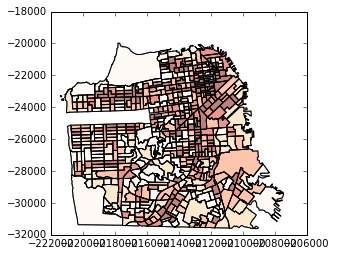

In [89]:
gdf.plot(column='RetailPSqMi', scheme='QUANTILES', colormap='OrRd')

Some more the more highly correlated varibles are not surprising - Retail density and bar density, poverty and bar density, poverty and retail, population density and retail density, population and bar density.

In [90]:
data.corr()    

,AssaultP1k,DrunkP1k,BarPSqMi,RetailPSqMi,Pop,PopDens1k,pMale,MedAge,pHHPov,VacantHU
AssaultP1k,1.000000,0.725607,0.247451,0.240172,-0.094178,0.006646,0.264967,-0.029781,0.412017,0.362845
DrunkP1k,0.725607,1.000000,0.360454,0.355921,-0.043434,0.057439,0.256697,-0.013782,0.327268,0.332010
BarPSqMi,0.247451,0.360454,1.000000,0.553718,0.055841,0.464139,0.220354,-0.039413,0.312509,0.196905
RetailPSqMi,0.240172,0.355921,0.553718,1.000000,0.034591,0.403884,0.085938,-0.021243,0.314261,0.150122
Pop,-0.094178,-0.043434,0.055841,0.034591,1.000000,0.273067,0.022302,-0.246674,0.088847,-0.056296
PopDens1k,0.006646,0.057439,0.464139,0.403884,0.273067,1.000000,0.137402,-0.094095,0.372978,0.086547
pMale,0.264967,0.256697,0.220354,0.085938,0.022302,0.137402,1.000000,-0.018096,0.021370,0.151776
MedAge,-0.029781,-0.013782,-0.039413,-0.021243,-0.246674,-0.094095,-0.018096,1.000000,0.014789,-0.017283
pHHPov,0.412017,0.327268,0.312509,0.314261,0.088847,0.372978,0.021370,0.014789,1.000000,0.204956
VacantHU,0.362845,0.332010,0.196905,0.150122,-0.056296,0.086547,0.151776,-0.017283,0.204956,1.000000


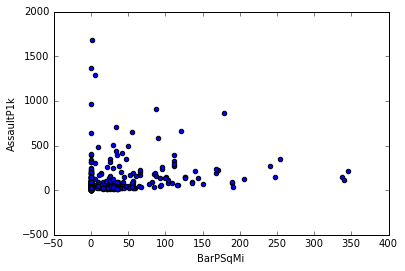

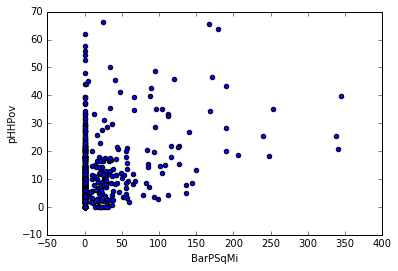

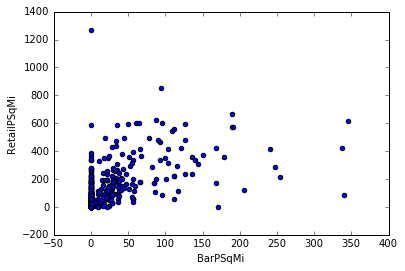

In [91]:
f=data.plot.scatter('BarPSqMi','AssaultP1k')
f=data.plot.scatter('BarPSqMi','pHHPov')
f=data.plot.scatter('BarPSqMi','RetailPSqMi')

In [126]:
#VarLabels={'AssaultP1k':'Assaults per 1k', 'DrunkP1k':'Drunk per 1k', 'pHHPov':'% HH in Poverty',
           #'BarPSqMi':'Bars per SqMi', 'RetailPSqMi':'Retail per SqMi','PopDens1k':'Pop Density (x1000)',
           #'pMale':'% Male','MedAge':'Median Age','VacantHU':'% Vacant Housing'}

In [117]:
YVar='DrunkP1k'
XVars=['pHHPov','BarPSqMi','RetailPSqMi','PopDens1k','pMale','VacantHU']
XVars=['pHHPov','BarPSqMi','RetailPSqMi','pMale','VacantHU']

#XVars=['BarPSqMi']

Y=data[YVar].as_matrix().reshape((len(data),1))
X=data[XVars].as_matrix()

print Y.shape, X.shape

(577, 1) (577, 5)


In [118]:
ols1=ps.spreg.OLS(Y,X,w=w, spat_diag=True,moran=True,name_y=YVar, name_x=XVars)
print ols1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    DrunkP1k                Number of Observations:         577
Mean dependent var  :      4.4709                Number of Variables   :           6
S.D. dependent var  :     11.9500                Degrees of Freedom    :         571
R-squared           :      0.2862
Adjusted R-squared  :      0.2800
Sum squared residual:   58712.226                F-statistic           :     45.7902
Sigma-square        :     102.824                Prob(F-statistic)     :   8.877e-40
S.E. of regression  :      10.140                Log likelihood        :   -2152.336
Sigma-square ML     :     101.754                Akaike info criterion :    4316.673
S.E of regression ML:     10.0873                Schwarz criterion     :    4342.820

-----------------------------------------------------------------------------

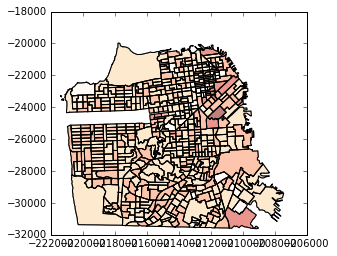

In [119]:
residuals=ols1.u
gpd.GeoDataFrame(residuals,geometry=geo.geometry.reset_index(drop=True)).plot(column=0, scheme='fisher_jenks',colormap='OrRd')

In [120]:
lag1=ps.spreg.ML_Lag(Y, X, w, name_y=YVar, name_x=XVars)
print lag1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    DrunkP1k                Number of Observations:         577
Mean dependent var  :      4.4709                Number of Variables   :           7
S.D. dependent var  :     11.9500                Degrees of Freedom    :         570
Pseudo R-squared    :      0.4080
Spatial Pseudo R-squared:  0.3038
Sigma-square ML     :      84.682                Log likelihood        :   -2111.104
S.E of regression   :       9.202                Akaike info criterion :    4236.208
                                                 Schwarz criterion     :    4266.712

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [121]:
lag2=ps.spreg.GM_Lag(Y, X, w=w, name_y=YVar, name_x=XVars)
print lag2.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    DrunkP1k                Number of Observations:         577
Mean dependent var  :      4.4709                Number of Variables   :           7
S.D. dependent var  :     11.9500                Degrees of Freedom    :         570
Pseudo R-squared    :      0.4107
Spatial Pseudo R-squared:  0.3030

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT     -11.3041662       2.9981265      -3.7704100       0.0001630
              pHHPov       0.0978933       0.0396369       2.4697498       0.0135208
            BarPSqMi       0.0234730       0.0108544       

In [122]:
b=lag1.betas[:-1]
rho=lag1.betas[-1]
btot=b/(1.0-rho)
bind=btot-b

#pd.DataFrame([b,bind])

pd.DataFrame(np.hstack([b,bind,btot]),index=['Constant']+XVars, columns=['Direct','Indirect','Total'])


,Direct,Indirect,Total
Constant,-11.668309,-10.207556,-21.875865
pHHPov,0.103305,0.090372,0.193677
BarPSqMi,0.023969,0.020968,0.044937
RetailPSqMi,0.012008,0.010505,0.022512
pMale,0.176157,0.154104,0.330261
VacantHU,0.280940,0.245769,0.526708


In [124]:
#error one
error1=ps.spreg.ML_Error(Y, X, w=w, name_y=YVar, name_x=XVars)
print error1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    DrunkP1k                Number of Observations:         577
Mean dependent var  :      4.4709                Number of Variables   :           6
S.D. dependent var  :     11.9500                Degrees of Freedom    :         571
Pseudo R-squared    :      0.2794
Sigma-square ML     :      84.514                Log likelihood        :   -2114.095
S.E of regression   :       9.193                Akaike info criterion :    4240.189
                                                 Schwarz criterion     :    4266.336

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [125]:
#spatial durbin
LagX = ps.lag_spatial(w, X)
NewX = np.hstack((X,LagX)) 
NewXNames=XVars+[x+'lag' for x in XVars]
durbin1=ps.spreg.ML_Lag(Y, NewX, w, name_y=YVar, name_x=NewXNames)
print durbin1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    DrunkP1k                Number of Observations:         577
Mean dependent var  :      4.4709                Number of Variables   :          12
S.D. dependent var  :     11.9500                Degrees of Freedom    :         565
Pseudo R-squared    :      0.4192
Spatial Pseudo R-squared:  0.3307
Sigma-square ML     :      83.053                Log likelihood        :   -2105.111
S.E of regression   :       9.113                Akaike info criterion :    4234.222
                                                 Schwarz criterion     :    4286.517

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------